In [75]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
###############################################################################
#Import package
###############################################################################

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

#Import common utilities
import math
from collections import Counter

# statsmodels
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels as statm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer

# Accuracy Evaluation
from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

# NLP
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import string
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
# Load dataset: calendar
calendar_df = pd.read_csv('C:\\DataScience\\00_AnalysisProjects\\AirbnbAnalysis\\Data\\seattle_calendar.csv')
calendar_df.shape   # (1393570, 4)

(1393570, 4)

In [7]:
# View data structure and content
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [8]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [9]:
# Check missing data
def Check_Missing_Data(df):    
    # count all missing values of each column
    total = df.isnull().sum().sort_values(ascending=True)
    # calculate percentage of null values for each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=True)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

Check_Missing_Data(calendar_df)

,Total,Percent
listing_id,0,0.00000
date,0,0.00000
available,0,0.00000
price,459028,0.32939


In [10]:
#  If the available values are f, the price values seems to be NaN. But it is only a hypothesis, is it true all data?
calendar1_df = calendar_df.groupby('available')['price'].count().reset_index()
calendar1_df.columns = ['available', 'price_nonnull_count']
calendar1_df

,available,price_nonnull_count
0,f,0
1,t,934542


In [12]:
# process data
calendar1_df = calendar_df.copy(deep=True)
calendar1_df.dropna(inplace=True)
calendar1_df['date'] = pd.to_datetime(calendar1_df['date'])
calendar1_df['price'] = calendar1_df['price'].str.replace("[$, ]", "").astype("float")

Check_Missing_Data(calendar1_df)

,Total,Percent
listing_id,0,0.0
date,0,0.0
available,0,0.0
price,0,0.0


In [13]:
# Recheck dimension of calendar after removing missing price
calendar1_df.shape 

(934542, 4)

In [21]:
# calculate sum and average of price by date
df1  = calendar1_df.groupby("date")[["price"]].sum()
df1["mean"]  = calendar1_df.groupby("date")[["price"]].mean()
df1.columns = ["Total", "Average"]
df1.head()

,Total,Average
date,,
2016-01-04,122.085879,122.085879
2016-01-05,120.681307,120.681307
2016-01-06,120.928258,120.928258
2016-01-07,120.958896,120.958896
2016-01-08,127.640853,127.640853


In [22]:
# set column date as index
df2 = calendar1_df.set_index("date")
# convert string to datetime
df2.index = pd.to_datetime(df2.index)
# resample data by month
df2 =  df2[["price"]].resample("M").mean()
df2.head()

,price
date,
2016-01-31,121.692505
2016-02-29,124.315614
2016-03-31,128.640797
2016-04-30,135.109460
2016-05-31,139.539566


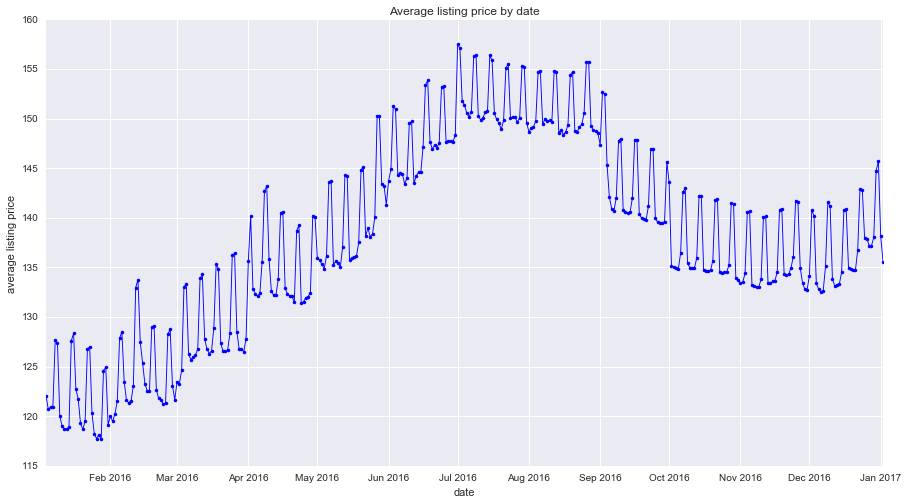

In [23]:
# process data
calendar1_df = calendar_df.copy(deep=True)
calendar1_df.dropna(inplace=True)
calendar1_df['date'] = pd.to_datetime(calendar1_df['date'])
calendar1_df['price'] = calendar1_df['price'].str.replace("[$, ]", "").astype("float")

# apply aggregation
calendar1_df = calendar1_df.groupby('date')['price'].mean().reset_index()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(calendar1_df.date, calendar1_df.price, color='b', marker='.', linewidth=0.9)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.show()

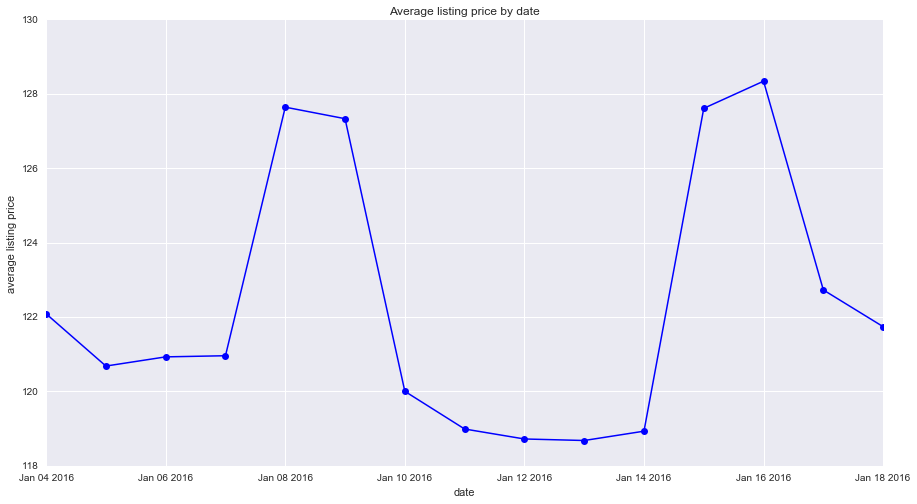

In [24]:
# plot more narrow range
plt.figure(figsize=(15, 8))
plt.plot(calendar1_df.date.values[:15], calendar1_df.price.values[:15], color='b', marker='o', linewidth=1.5)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.show()

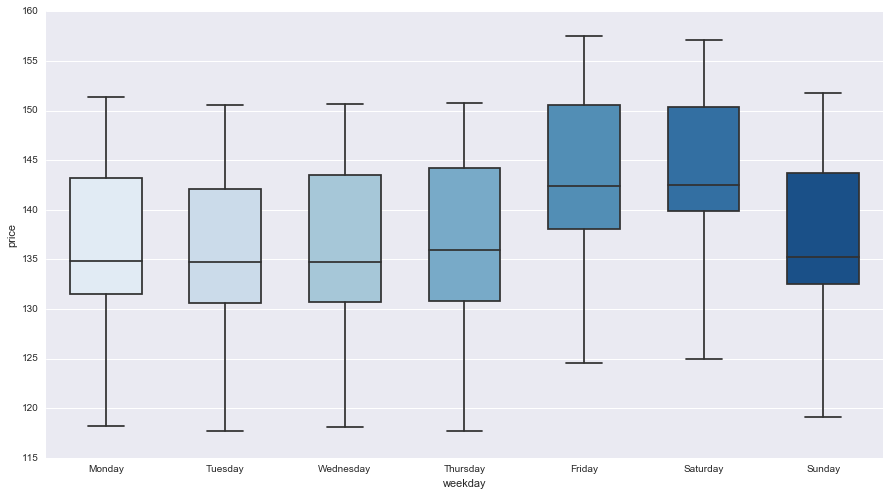

In [25]:
# create weekday column
calendar1_df["weekday"] = calendar1_df["date"].dt.weekday_name

# boxplot to see price distribution
plt.figure(figsize=(15, 8))
sns.boxplot(x = 'weekday',  y = 'price', data = calendar1_df, palette="Blues", width=0.6)
plt.show()

In [34]:
# remove NaN rows for a subset of columns
calendar1_df = calendar_df.dropna(subset=['price'])

In [35]:
# remove NaN rows for all columns
calendar_df1 = calendar_df.dropna()
calendar_df1.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
9,241032,2016-01-13,t,$85.00
10,241032,2016-01-14,t,$85.00
14,241032,2016-01-18,t,$85.00


In [36]:
# Histogram for price distribution
calendar1_df['price'] = calendar1_df['price'].str.replace("[$, ]", "").astype("float")
mean_price_for_calendar = calendar1_df.groupby('listing_id').mean()['price']

In [37]:
mean_price_for_calendar.head()#plot
plt.figure(figsize=(15,7))
plt.hist(mean_price_for_calendar, bins=50)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Number of listings depending on price')
plt.show()

listing_id
3335    120.000000
4291     82.000000
5682     53.944984
6606     92.849315
7369     85.000000
Name: price, dtype: float64

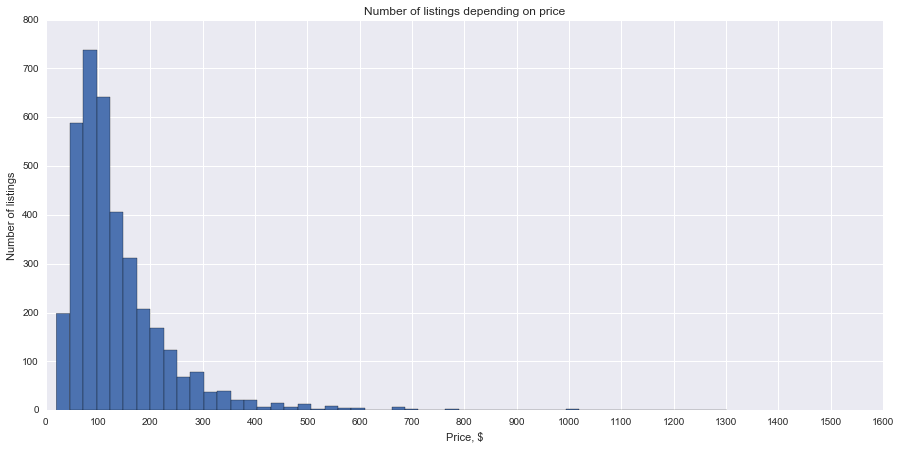

In [38]:
#plot
plt.figure(figsize=(15,7))
plt.hist(mean_price_for_calendar, bins=50)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Number of listings depending on price')
plt.show()

In [51]:
# process data
calendar1_df = calendar_df.copy(deep=True)
calendar1_df.dropna(inplace=True)
calendar1_df['date'] = pd.to_datetime(calendar1_df['date'])
calendar1_df['price'] = calendar1_df['price'].str.replace("[$, ]", "").astype("float")

# extract year, month for each date
calendar1_df['year'] = calendar1_df.date.dt.year
calendar1_df['month'] = calendar1_df.date.dt.month

calendar1_df.head()

,listing_id,date,available,price,year,month
0,241032,2016-01-04,t,85.0,2016,1
1,241032,2016-01-05,t,85.0,2016,1
9,241032,2016-01-13,t,85.0,2016,1
10,241032,2016-01-14,t,85.0,2016,1
14,241032,2016-01-18,t,85.0,2016,1


In [45]:
number_of_listings_by_month = calendar1_df.groupby('month').listing_id.count()
number_of_listings_by_month

month
1     64937
2     73321
3     83938
4     76037
5     79971
6     77244
7     74222
8     76347
9     77246
10    82438
11    81780
12    87061
Name: listing_id, dtype: int64

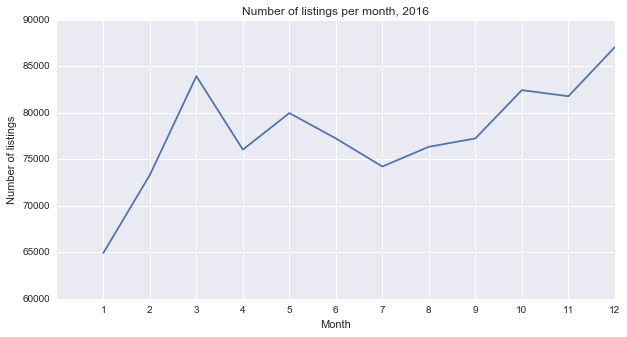

In [46]:
# Line plot
plt.figure(figsize=(10,5))
plt.plot(number_of_listings_by_month)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')
plt.show()

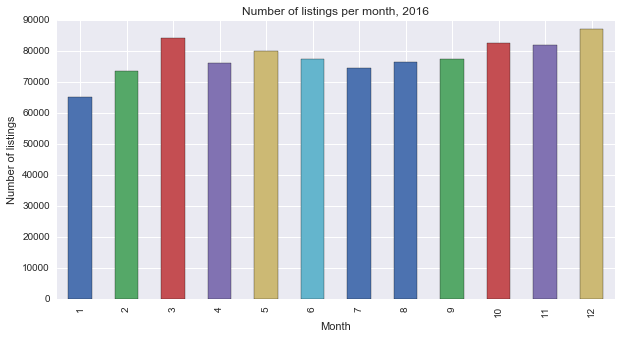

In [47]:
# bar plot
plt.figure(figsize=(10,5))
number_of_listings_by_month.plot(kind='bar', x=number_of_listings_by_month.index.values, y=number_of_listings_by_month.values, legend = False)
plt.ylabel('Number of listings')
plt.xlabel('Month') 
plt.title('Number of listings per month, 2016')
plt.show()

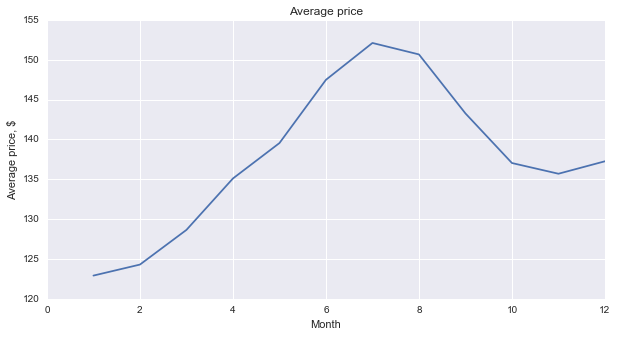

In [52]:
#find average price by month
average_price_by_month = calendar1_df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')
plt.show()

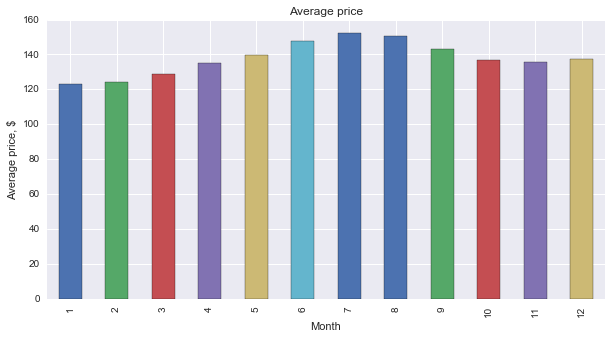

In [53]:
# bar plot
plt.figure(figsize=(10,5))
average_price_by_month.plot(kind='bar', x=average_price_by_month.index.values, y=average_price_by_month.values, legend = False)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')
plt.show()

### Visualization

In [76]:
import plotly as py
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.offline as offline

In [77]:
trace1 = go.Scatter(
    x = df1.index,
    y = df1["Total"]
)
data = [trace1]
layout = go.Layout(
    title = "Price by each time",
    xaxis  = dict(title = "Time"),
    yaxis = dict(title = "Total ($)")
)
trace2 = go.Scatter(
    x = df1.index,
    y = df1["Average"]
)

data2 = [trace2]
layout2 = go.Layout(
    title = "Price by each time",
    xaxis  = dict(title = "Time"),
    yaxis = dict(title = "Mean ($)")
)
fig = go.Figure(data = data, layout = layout)
fig2 = go.Figure(data = data2, layout = layout2)


In [78]:
# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb
offline.iplot(fig)

In [79]:
# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb
offline.iplot(fig2)

In [80]:
trace3 = go.Scatter(
    x = df2.index[:-1],
    y = df2.price[:-1]
)
layout3 = go.Layout(
    title = "Average price by month",
    xaxis = dict(title = "time"),
    yaxis = dict(title = "Price")
)
data3 = [trace3]
fig3 = go.Figure(data= data3, layout= layout3)

# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb
offline.iplot(fig3)

### Time series stationarity and using statistic test

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [82]:
def draw_interactive_graph(mode):
    df1.index = pd.to_datetime(df1.index)
    decomposition = seasonal_decompose(df1[[mode]])
    trace4_1 = go.Scatter(
        x = decomposition.observed.index, 
        y = decomposition.observed[mode],
        name = "Observed"
    )
    trace4_2 = go.Scatter(
        x = decomposition.trend.index,
        y = decomposition.trend[mode],
        name = "Trend"
    )
    trace4_3 = go.Scatter(
        x = decomposition.seasonal.index,
        y = decomposition.seasonal[mode],
        name = "Seasonal"
    )
    trace4_4 = go.Scatter(
        x = decomposition.resid.index,
        y = decomposition.resid[mode],
        name = "Resid"
    )

    fig = py.tools.make_subplots(rows=4, cols=1, subplot_titles=('Observed', 'Trend',
                                                              'Seasonal', 'Residiual'))
    # append trace into fig
    fig.append_trace(trace4_1, 1, 1)
    fig.append_trace(trace4_2, 2, 1)
    fig.append_trace(trace4_3, 3, 1)
    fig.append_trace(trace4_4, 4, 1)

    fig['layout'].update( title='Descompose with TimeSeries')
    offline.iplot(fig)

In [83]:
draw_interactive_graph("Average")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



In [84]:
draw_interactive_graph("Total")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



In [85]:
calendar_clean = calendar_df.dropna()
calendar_clean.set_index("date", inplace = True)
calendar_clean.head()

,listing_id,available,price
date,,,
2016-01-04,241032,t,$85.00
2016-01-05,241032,t,$85.00
2016-01-13,241032,t,$85.00
2016-01-14,241032,t,$85.00
2016-01-18,241032,t,$85.00


In [86]:
calendar_clean.index = pd.to_datetime(calendar_clean.index)
number_hire_room = calendar_clean.resample("M")[["price"]].count()
total_price_each_month  = calendar_clean.resample("M")[["price"]].sum()

In [87]:
trace5 = go.Scatter(
    x = number_hire_room.index[:-1],
    y = number_hire_room.price[:-1]
)
data5 = [trace5]
layout5 = go.Layout(
    title = "Number of Hire Room by Month in London",
    xaxis = dict(title = "Month"),
    yaxis = dict(title = "Number hirde")
)
fig5  = go.Figure(data = data5, layout = layout5)

offline.iplot(fig5)

In [88]:
trace6 = go.Scatter(
    x = number_hire_room.index[:-1],
    y = number_hire_room.price[:-1]/number_hire_room.price[0]
)
data6 = [trace6]
layout6 = go.Layout(
    title = "the ratio of the number of rooms compare with the first month",
    xaxis = dict(title = "Month"),
    yaxis = dict(title = "Ratio")
)
fig6 = go.Figure(data = data6, layout = layout6)

offline.iplot(fig6)

In [89]:
from scipy import stats

In [42]:
a = calendar_clean.index.month
# calendar_clean["Month"] = a
calendar_clean = calendar_clean.assign(Month = a)
calendar_clean.head()

,listing_id,available,price,Month
date,,,,
2019-11-25,9554,t,35.0,11
2019-11-24,9554,t,35.0,11
2019-11-23,9554,t,39.0,11
2019-11-22,9554,t,39.0,11
2019-11-21,9554,t,35.0,11


In [27]:


result = []
for i in range(1,13):
    result.append(np.array([calendar_clean[calendar_clean["Month"] == i].price]))



In [28]:
data_score = []
for i in range(11):
    score = stats.ttest_rel(result[i][0][:64911],result[-1][0][:64911])
    data_score.append((score[0], score[1]))

In [29]:
score_board = pd.DataFrame(data = data_score, columns = ["Test Statistic", "P_value"])
score_board["Month"] = range(1, 12)
score_board.set_index("Month", inplace = True)
score_board

,Test Statistic,P_value
Month,,
1,-14.907433,3.571048e-50
2,-15.748268,8.957391e-56
3,-14.036928,1.077138e-44
4,-10.806497,3.382590e-27
5,-11.480491,1.769421e-30
6,-6.952102,3.632667e-12
7,-2.532751,1.131948e-02
8,-0.698523,4.848527e-01
9,-5.631242,1.796535e-08


In [ ]:
offline.iplot(fig3)#Extracting prices from the table
calendar_df['price'] = (calendar_df['price'].str.replace(r'[^-+\d.]', '').astype(float))
calendar_df.tail(30)
calendar_df = calendar_df.sort_values(by='date', ascending=True)
calendar_df['date_bk'] = calendar_df['date']
calendar_df['date_bk'] = pd.to_datetime(calendar_df['date_bk'])
calendar_df.head(10)

# change to index 
calendar_df.set_index('date',inplace=True) 
calendar_df.index = pd.to_datetime(calendar_df.index)
ts_calendar = calendar_df['price']
ts_calendar.tail(50)

# Resample the data
ts_calendar_week = ts_calendar.resample('W').mean()
plt.figure(figsize=(12, 6))
plt.plot(ts_calendar_week.index, ts_calendar_week.values)
ts_calendar_month = ts_calendar.resample('M').mean()

#getting day name from date data and holidays
calendar_df.fillna(0, inplace=True)
calendar_df.shape
uk_holidays = holidays.UK()
calendar_df['day_Name']='default'
calendar_df['holiday']='False'
calendar_df['uk_holidays_name']='working'
calendar_df['date_bk'] = pd.to_datetime(calendar_df['date_bk']).apply(lambda x: x.date())
calendar_df['day_Name'] = calendar_df['date_bk'].apply(lambda x: calendar.day_name[x.weekday()])
calendar_df['holiday'] = calendar_df['date_bk'].apply(lambda x: x in uk_holidays)
calendar_df['uk_holidays_name'] = calendar_df['date_bk'].apply(lambda x: uk_holidays.get(x))
calendar_df.head()
calendar_df.loc[calendar_df.uk_holidays_name == 'Boxing Day',:].shape

#calculating Average price for each day
day_df = calendar_df.groupby('day_Name').price.mean()
day_df = day_df.reset_index()
day_df['day_num'] = 0
for index,row in day_df.iterrows():
    if row['day_Name']=='Monday':
        day_df.set_value(index,'day_num',1)
    if row['day_Name']=='Tuesday':
        day_df.set_value(index,'day_num',2)
    if row['day_Name']=='Wednesday':
        day_df.set_value(index,'day_num',3)
    if row['day_Name']=='Thursday':
        day_df.set_value(index,'day_num',4)
    if row['day_Name']=='Friday':
        day_df.set_value(index,'day_num',5)
    if row['day_Name']=='Saturday':
        day_df.set_value(index,'day_num',6)
    if row['day_Name']=='Sunday':
        day_df.set_value(index,'day_num',7)
day_df = day_df.sort_values('day_num',ascending=[1])
day_df = day_df.rename(columns={'price':'Average_Price'})
day_df


#checking which holiday has maximum listings
holiday_df = calendar_df.groupby('uk_holidays_name').listing_id.count()
holiday_df = holiday_df.reset_index()
holiday_df = holiday_df .sort_values('listing_id',ascending=[0])
holiday_df
plt.figure(figsize=(15,7))
ax = sns.barplot("uk_holidays_name", y="listing_id", data=holiday_df,palette="Blues_d")
ax.set(xlabel='UK Holidays Name', ylabel='Total Number of Listings')

#checking which holiday has maximum prices
holidayPrice_df = calendar_df.groupby('uk_holidays_name').price.mean()
holidayPrice_df = holidayPrice_df.reset_index()
holidayPrice_df = holidayPrice_df.sort_values('price',ascending=[0])
holidayPrice_df.head(10)
plt.figure(figsize=(15,8))
ax = sns.barplot("uk_holidays_name", y="price", data=holidayPrice_df,palette="Blues_d")
ax.set(xlabel='UK Holidays Name', ylabel='Average Price')

# merge holiday listings and holiday price
merger = pd.merge(holiday_df,holidayPrice_df,on='uk_holidays_name')
merger = merger.rename(columns={'listing_id':'number_Of_Listings'})
merger = merger.rename(columns={'price':'average_Price'})
merger

# analyzing data from date 5th of October to date 13th of October which includes both long weekend and normal workdays
July_df = calendar_df['2019-07']
July_df = pd.DataFrame(July_df.groupby(['date_bk']).price.mean())
July_df['date'] = July_df.index.values
July_df['day_Name'] = July_df['date'].apply(lambda x:calendar.day_name[x.weekday()])
July_df['uk_holidays_name'] = July_df['date'].apply(lambda x: uk_holidays.get(x))
July_df = July_df.rename(columns={'price':'Average_Price'})

plt.figure(figsize=(15,8))
plt.plot(July_df.index, July_df.Average_Price, 'ro-')
plt.ylabel('Average Price')
plt.xlabel('Days')


In [56]:
calendar1_df['log_price']  = calendar1_df['price'].apply(lambda x: math.log(x))
calendar1_df.head(10)

,listing_id,date,available,price,year,month,log_price
0,241032,2016-01-04,t,85.0,2016,1,4.442651
1,241032,2016-01-05,t,85.0,2016,1,4.442651
9,241032,2016-01-13,t,85.0,2016,1,4.442651
10,241032,2016-01-14,t,85.0,2016,1,4.442651
14,241032,2016-01-18,t,85.0,2016,1,4.442651
15,241032,2016-01-19,t,85.0,2016,1,4.442651
16,241032,2016-01-20,t,85.0,2016,1,4.442651
20,241032,2016-01-24,t,85.0,2016,1,4.442651
21,241032,2016-01-25,t,85.0,2016,1,4.442651
22,241032,2016-01-26,t,85.0,2016,1,4.442651


In [58]:
# Only consider data for which there is data
nan_adjusted = calendar1_df[np.isfinite(calendar1_df['log_price'])]
#Still left with a reasonable amount of observations 
nan_adjusted.shape  # (9468074, 5)
# Group by listing_id, then find each listing id's average price
grouped = nan_adjusted.groupby(['listing_id'], as_index = False)

In [59]:
print("number of unique properties:", len(nan_adjusted['listing_id'].unique()))
# Let's sort to make things easier on pattern matching algorithm
nan_adjusted.sort_values(['listing_id'], inplace=True)
nan_adjusted.reset_index(inplace=True)
nan_adjusted.head(10)

number of unique properties: 3723


,index,listing_id,date,available,price,year,month,log_price
0,797479,3335,2016-11-18,t,120.0,2016,11,4.787492
1,797415,3335,2016-09-15,t,120.0,2016,9,4.787492
2,797414,3335,2016-09-14,t,120.0,2016,9,4.787492
3,797413,3335,2016-09-13,t,120.0,2016,9,4.787492
4,797412,3335,2016-09-12,t,120.0,2016,9,4.787492
5,797411,3335,2016-09-11,t,120.0,2016,9,4.787492
6,797410,3335,2016-09-10,t,120.0,2016,9,4.787492
7,797409,3335,2016-09-09,t,120.0,2016,9,4.787492
8,797408,3335,2016-09-08,t,120.0,2016,9,4.787492
9,797407,3335,2016-09-07,t,120.0,2016,9,4.787492


In [60]:
mean_df = grouped.mean()
mean_df['listing_id']
mean_df.head()

,listing_id,index,price,year,month,log_price
0,3335,4.814300e+05,91.310680,2016.006472,6.660194,4.512812
1,4291,2.498705e+05,512.602740,2016.005479,6.430137,6.235810
2,5682,9.662255e+05,88.330097,2016.009709,5.546926,4.451176
3,6606,3.523613e+05,141.824658,2016.010959,6.926027,4.824844
4,7369,1.083640e+06,89.622642,2016.037736,10.698113,4.495068


In [61]:
average_price_df = grouped['price'].mean()
average_price_df.head()

,listing_id,price
0,3335,91.310680
1,4291,512.602740
2,5682,88.330097
3,6606,141.824658
4,7369,89.622642


In [63]:
average_logprice_df = grouped['log_price'].mean()
average_logprice_df.head()

,listing_id,log_price
0,3335,4.512812
1,4291,6.235810
2,5682,4.451176
3,6606,4.824844
4,7369,4.495068


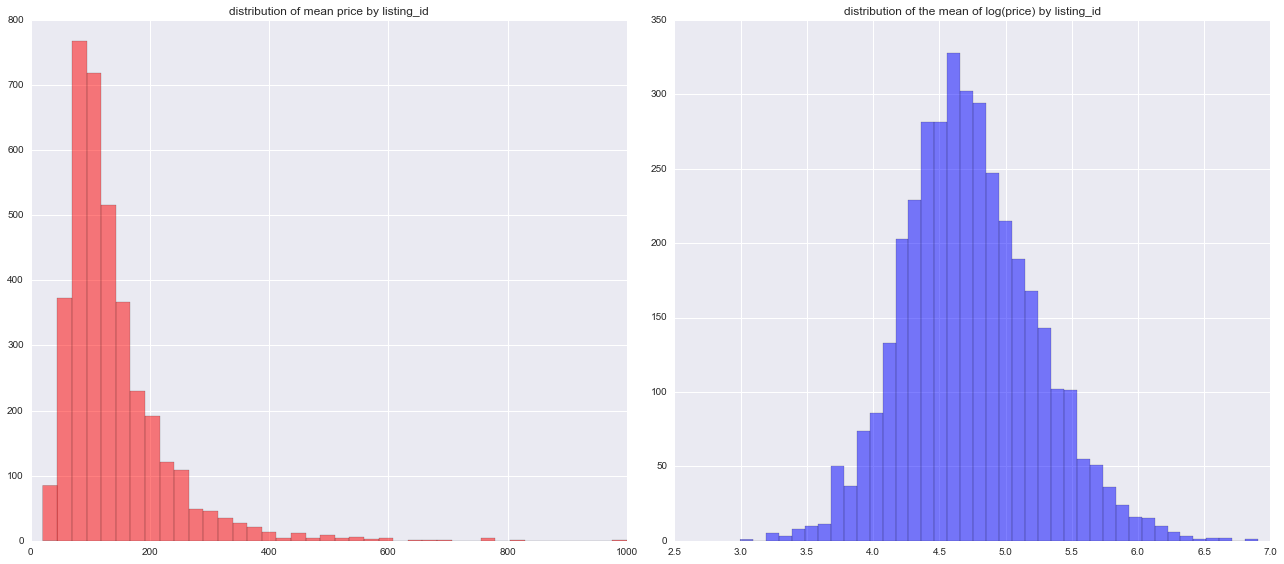

In [64]:
# Examine Distribution of average price by listing_id
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(18, 8))
ax1.hist(average_price_df['price'], color='red', bins=40, alpha=0.5)
ax1.set_title('distribution of mean price by listing_id')
ax2.hist(average_logprice_df['log_price'], color='blue', bins=40, alpha=0.5)
ax2.set_title('distribution of the mean of log(price) by listing_id')
plt.tight_layout()
plt.show()

In [65]:
average_price_df = average_price_df.merge(average_logprice_df,how='left', left_on='listing_id', right_on='listing_id')
average_price_df.columns = ['listing_id','avg_price','avg_log_price']
average_price_df.head()

,listing_id,avg_price,avg_log_price
0,3335,91.310680,4.512812
1,4291,512.602740,6.235810
2,5682,88.330097,4.451176
3,6606,141.824658,4.824844
4,7369,89.622642,4.495068


In [66]:
# Initialize an empty column for the price differences 
nan_adjusted['price_diff'] = 0
nan_adjusted = nan_adjusted.merge(average_price_df,how='left', left_on='listing_id', right_on='listing_id')
nan_adjusted['price_diff'] = nan_adjusted['price'] - nan_adjusted['avg_price']
nan_adjusted['date'] = pd.to_datetime(nan_adjusted['date'])
nan_adjusted.head()

,index,listing_id,date,available,price,year,month,log_price,price_diff,avg_price,avg_log_price
0,797479,3335,2016-11-18,t,120.0,2016,11,4.787492,28.68932,91.31068,4.512812
1,797415,3335,2016-09-15,t,120.0,2016,9,4.787492,28.68932,91.31068,4.512812
2,797414,3335,2016-09-14,t,120.0,2016,9,4.787492,28.68932,91.31068,4.512812
3,797413,3335,2016-09-13,t,120.0,2016,9,4.787492,28.68932,91.31068,4.512812
4,797412,3335,2016-09-12,t,120.0,2016,9,4.787492,28.68932,91.31068,4.512812


In [67]:
# Groupby datetime, get average price difference
final = nan_adjusted.groupby(['date'], as_index = False)
final_sums = final['price_diff'].mean()
print ("Number of days average price difference was positive:", sum(final_sums['price_diff']>0))

Number of days average price difference was positive: 175


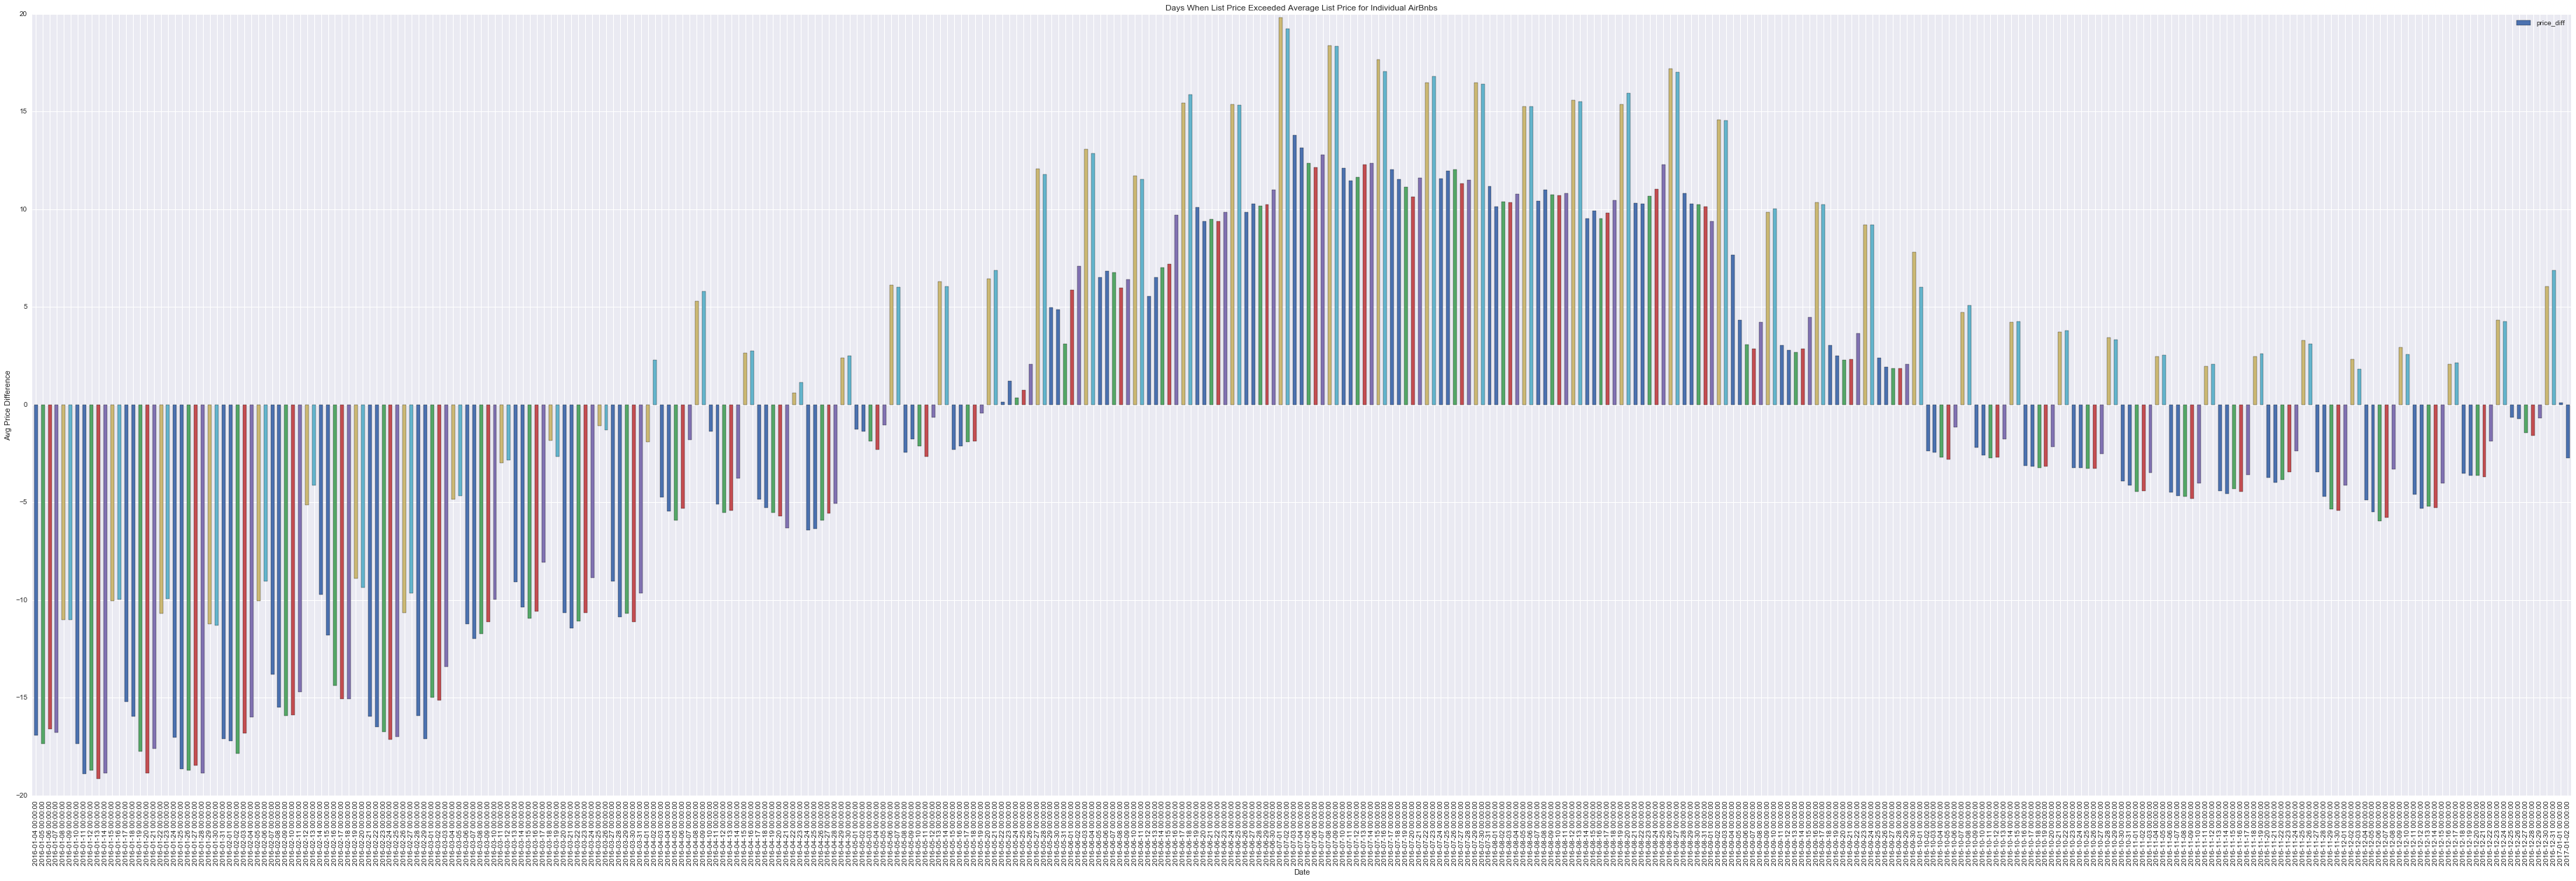

In [68]:
# Examine overall price difference trend
fig, ax = plt.subplots(1, 1, figsize=(65, 20))
final_sums.plot(kind='bar', x= 'date', y='price_diff', ax=ax)
ax.set_xticklabels(final_sums['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Days When List Price Exceeded Average List Price for Individual AirBnbs')
plt.show()

In [69]:
# Subset the data for easier viewing 
fall = final_sums[(final_sums['date'] > '2016-09-22') & (final_sums['date'] < '2016-12-22')] 
winter = final_sums[(final_sums['date'] > '2016-12-21') | (final_sums['date'] < '2016-03-20')] 
spring = final_sums[(final_sums['date'] > '2016-03-19') & (final_sums['date'] < '2016-06-21')] 
summer = final_sums[(final_sums['date'] > '2016-06-20') & (final_sums['date'] < '2016-09-23')]

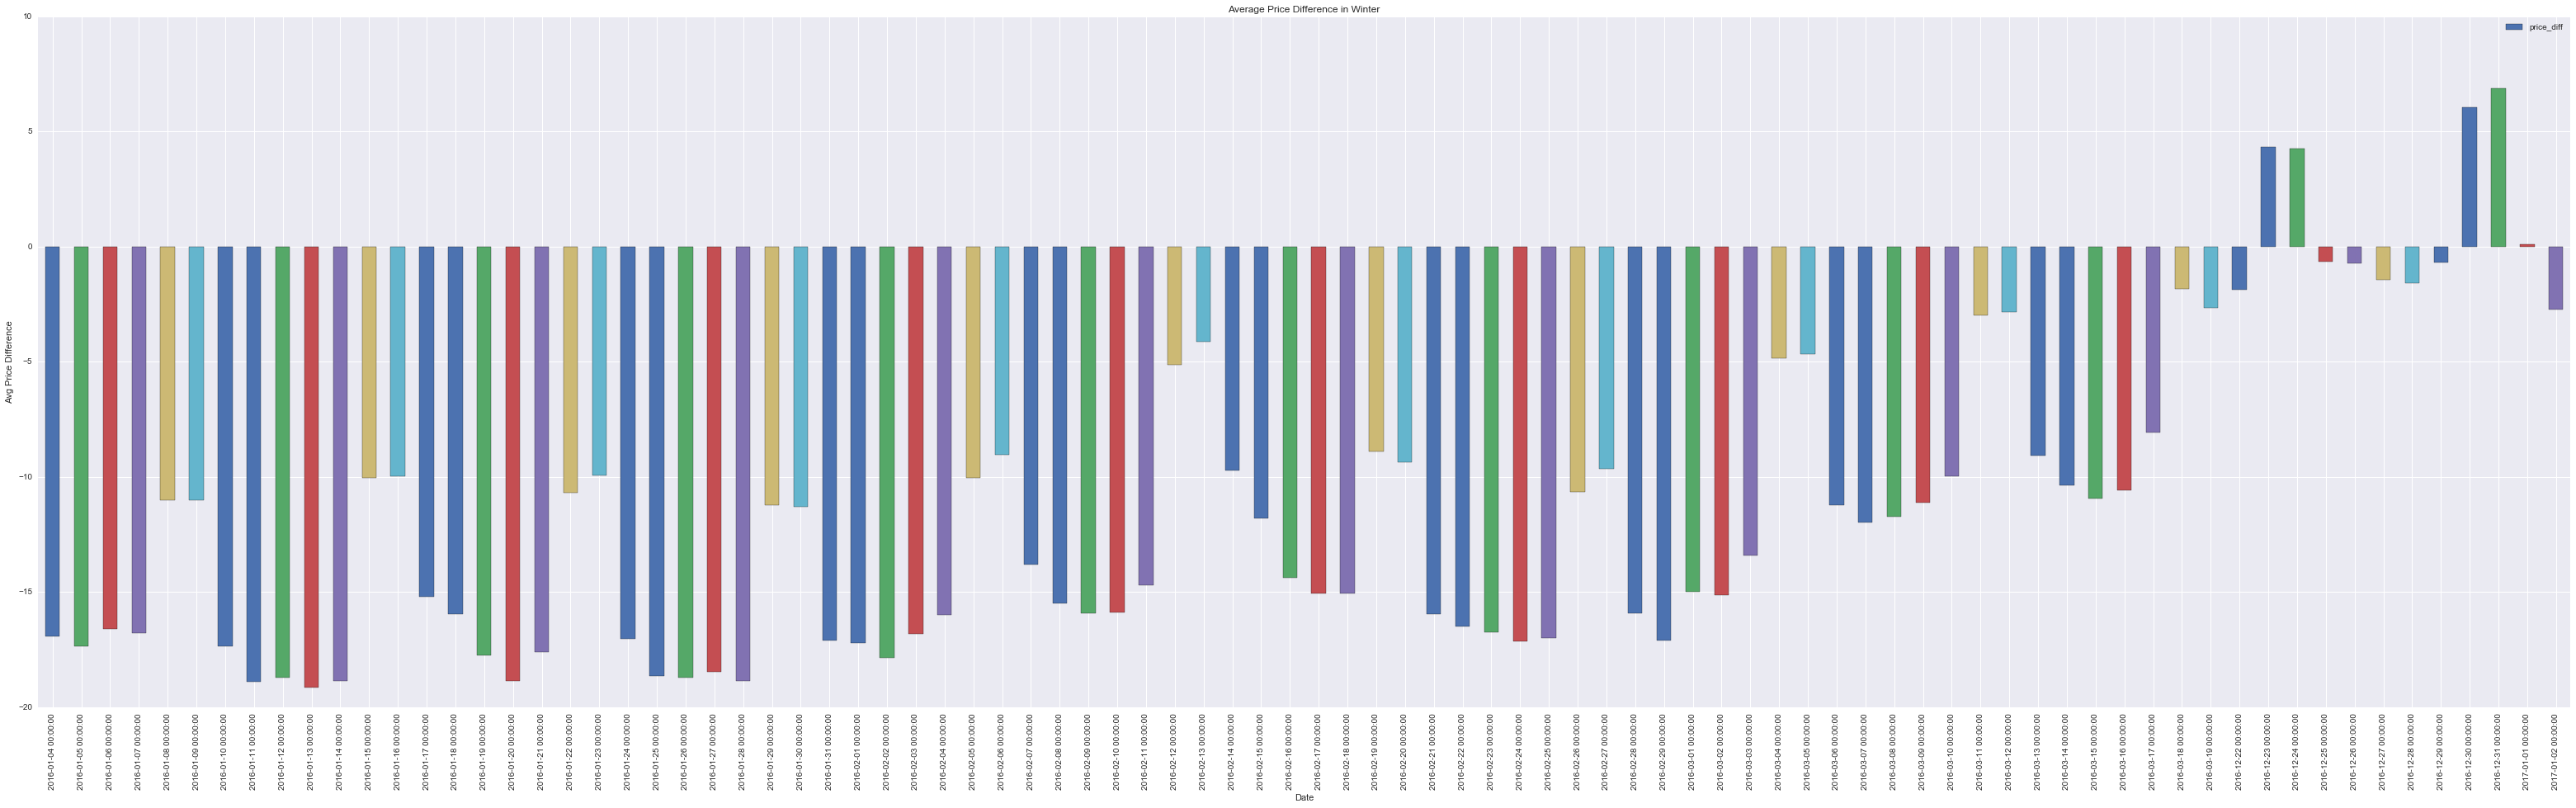

In [70]:
# WINTER 
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
winter.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(winter['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Winter')
plt.show()

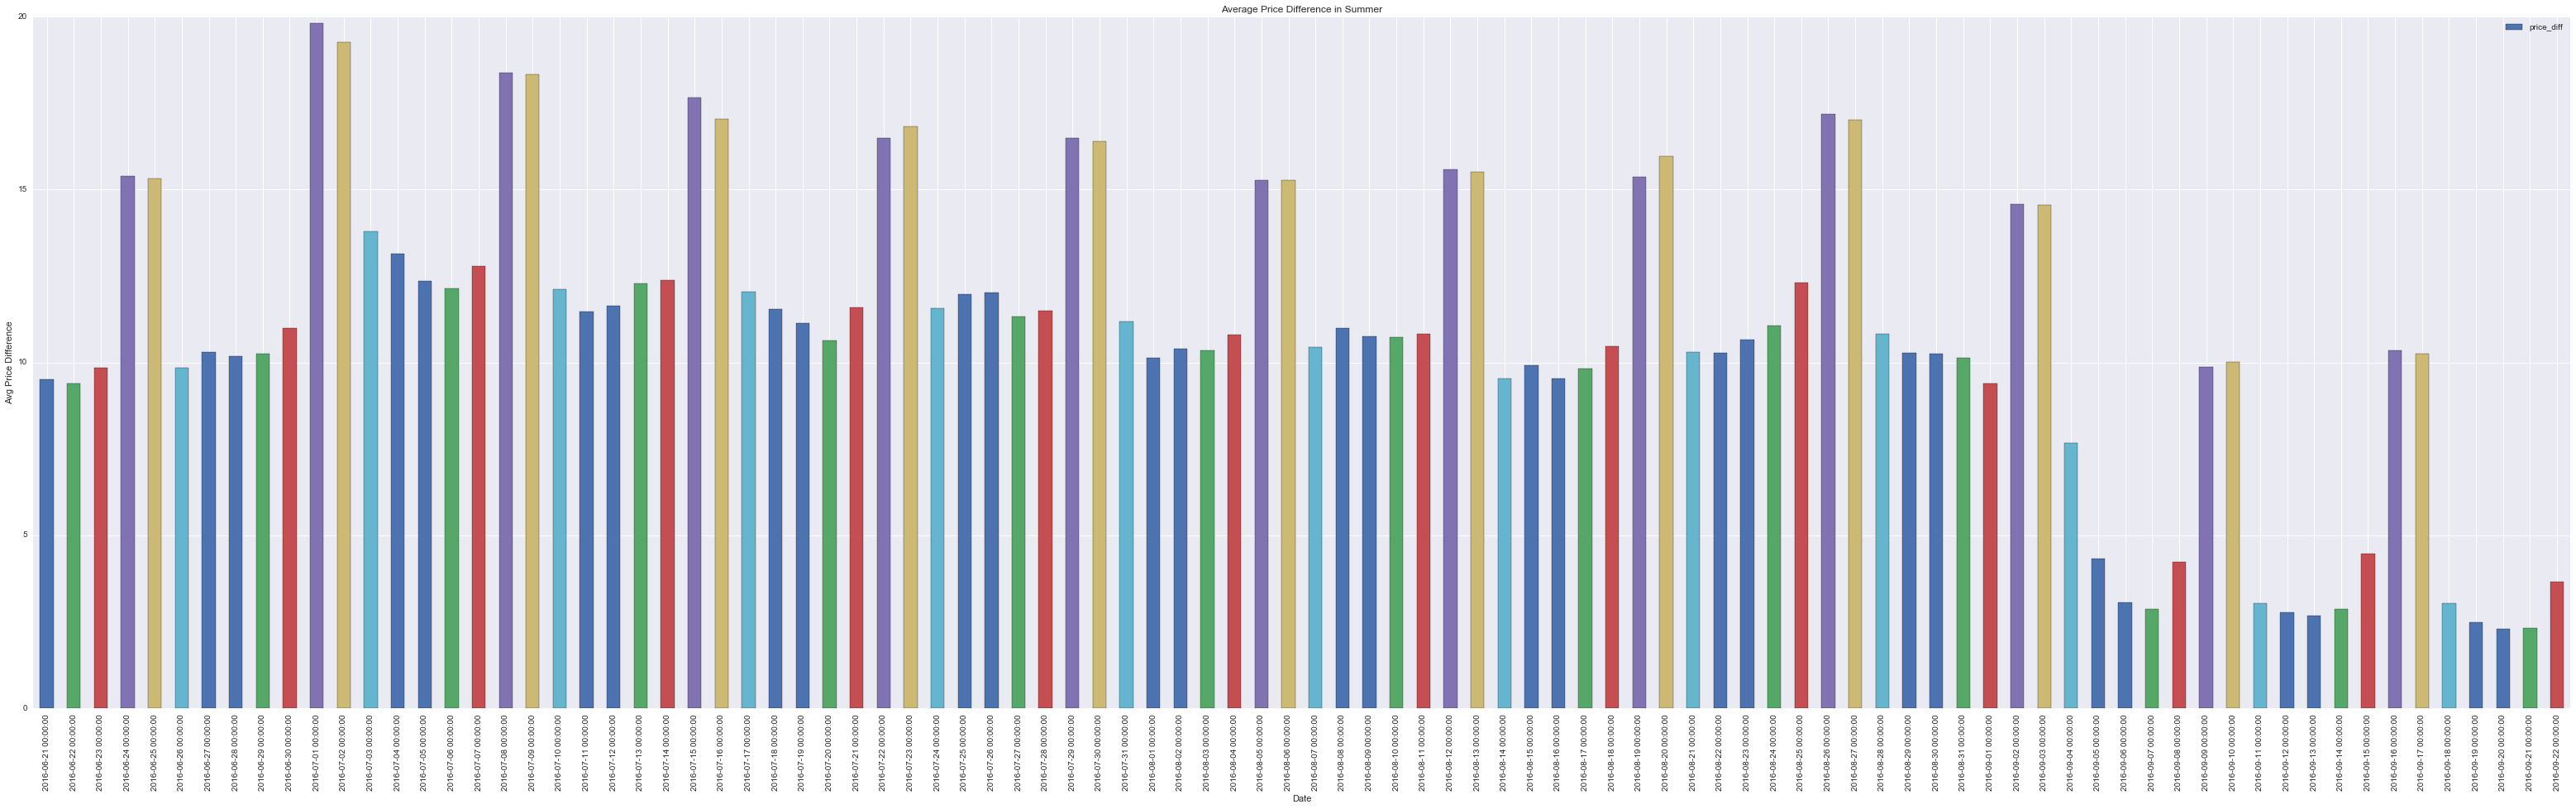

In [71]:
# SUMMER 
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
summer.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(summer['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Summer')
plt.show()

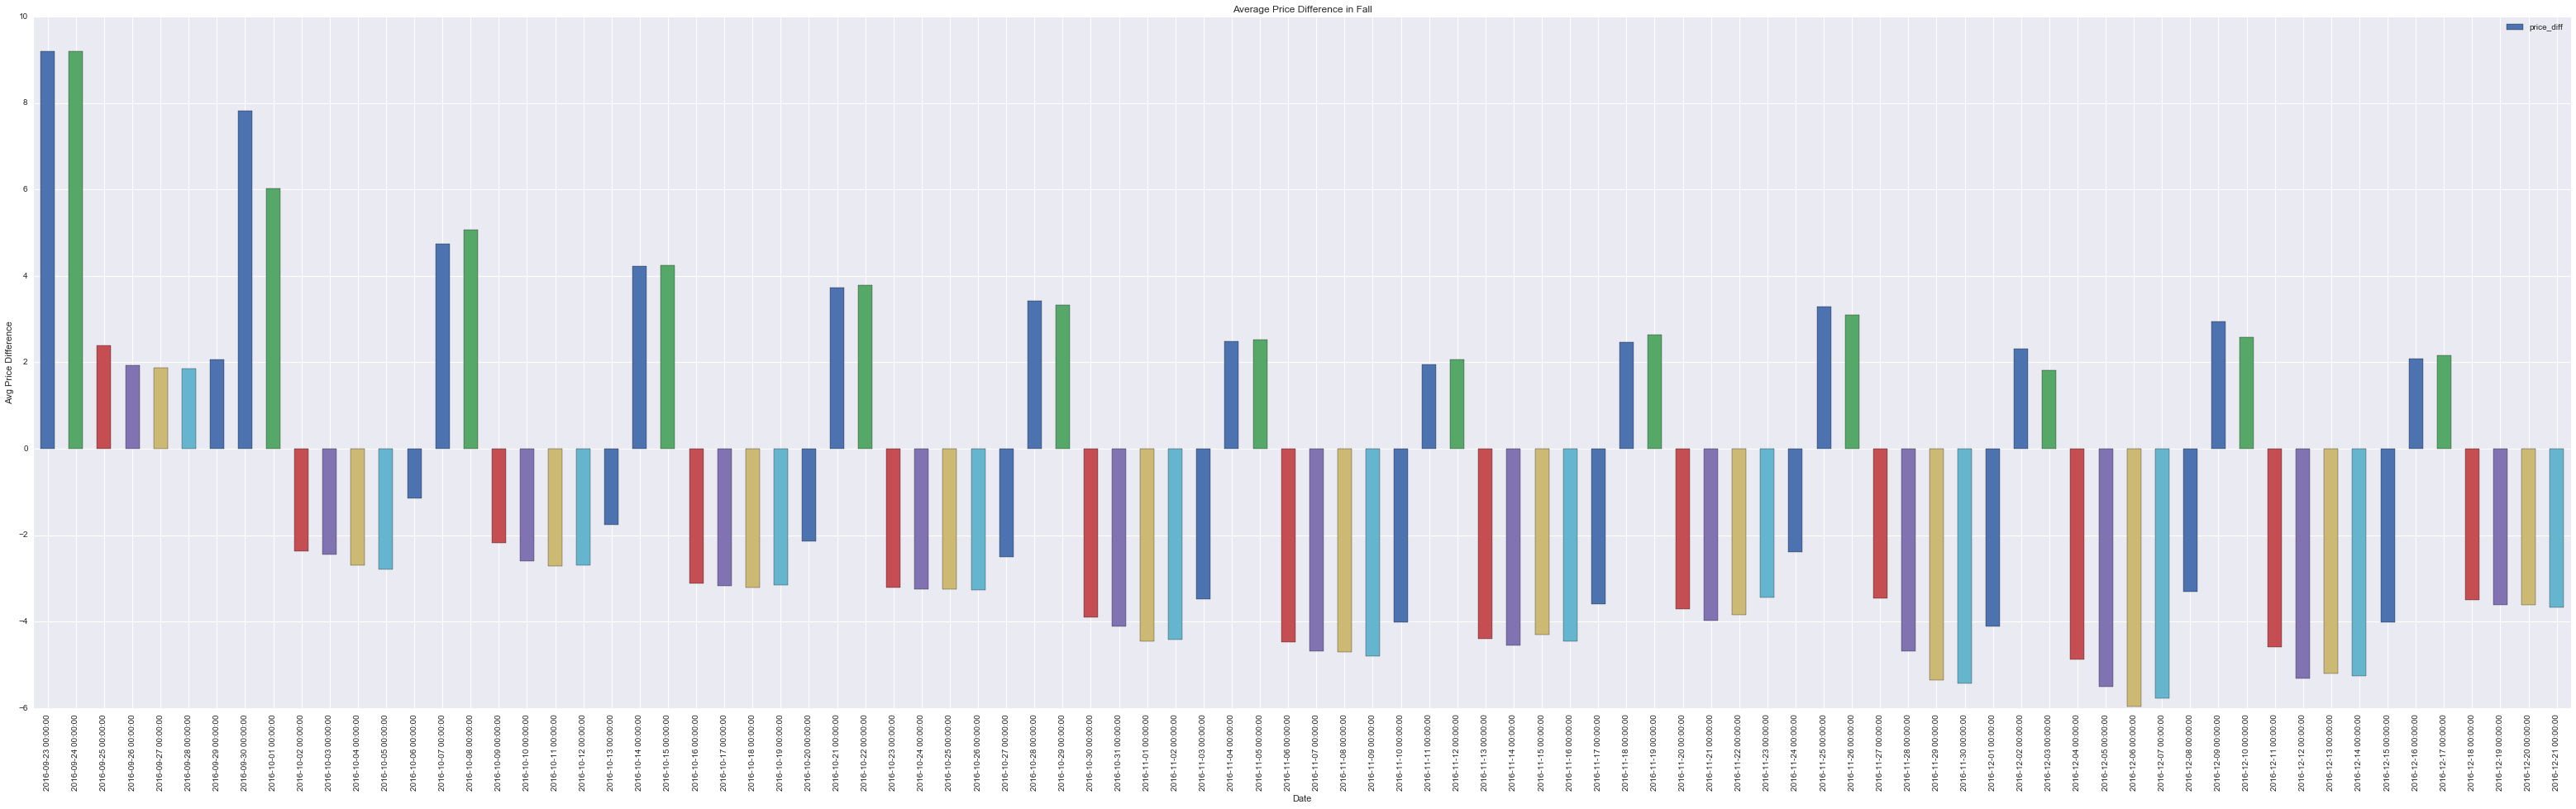

In [72]:
#FALL
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
fall.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(fall['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Fall')
plt.show()

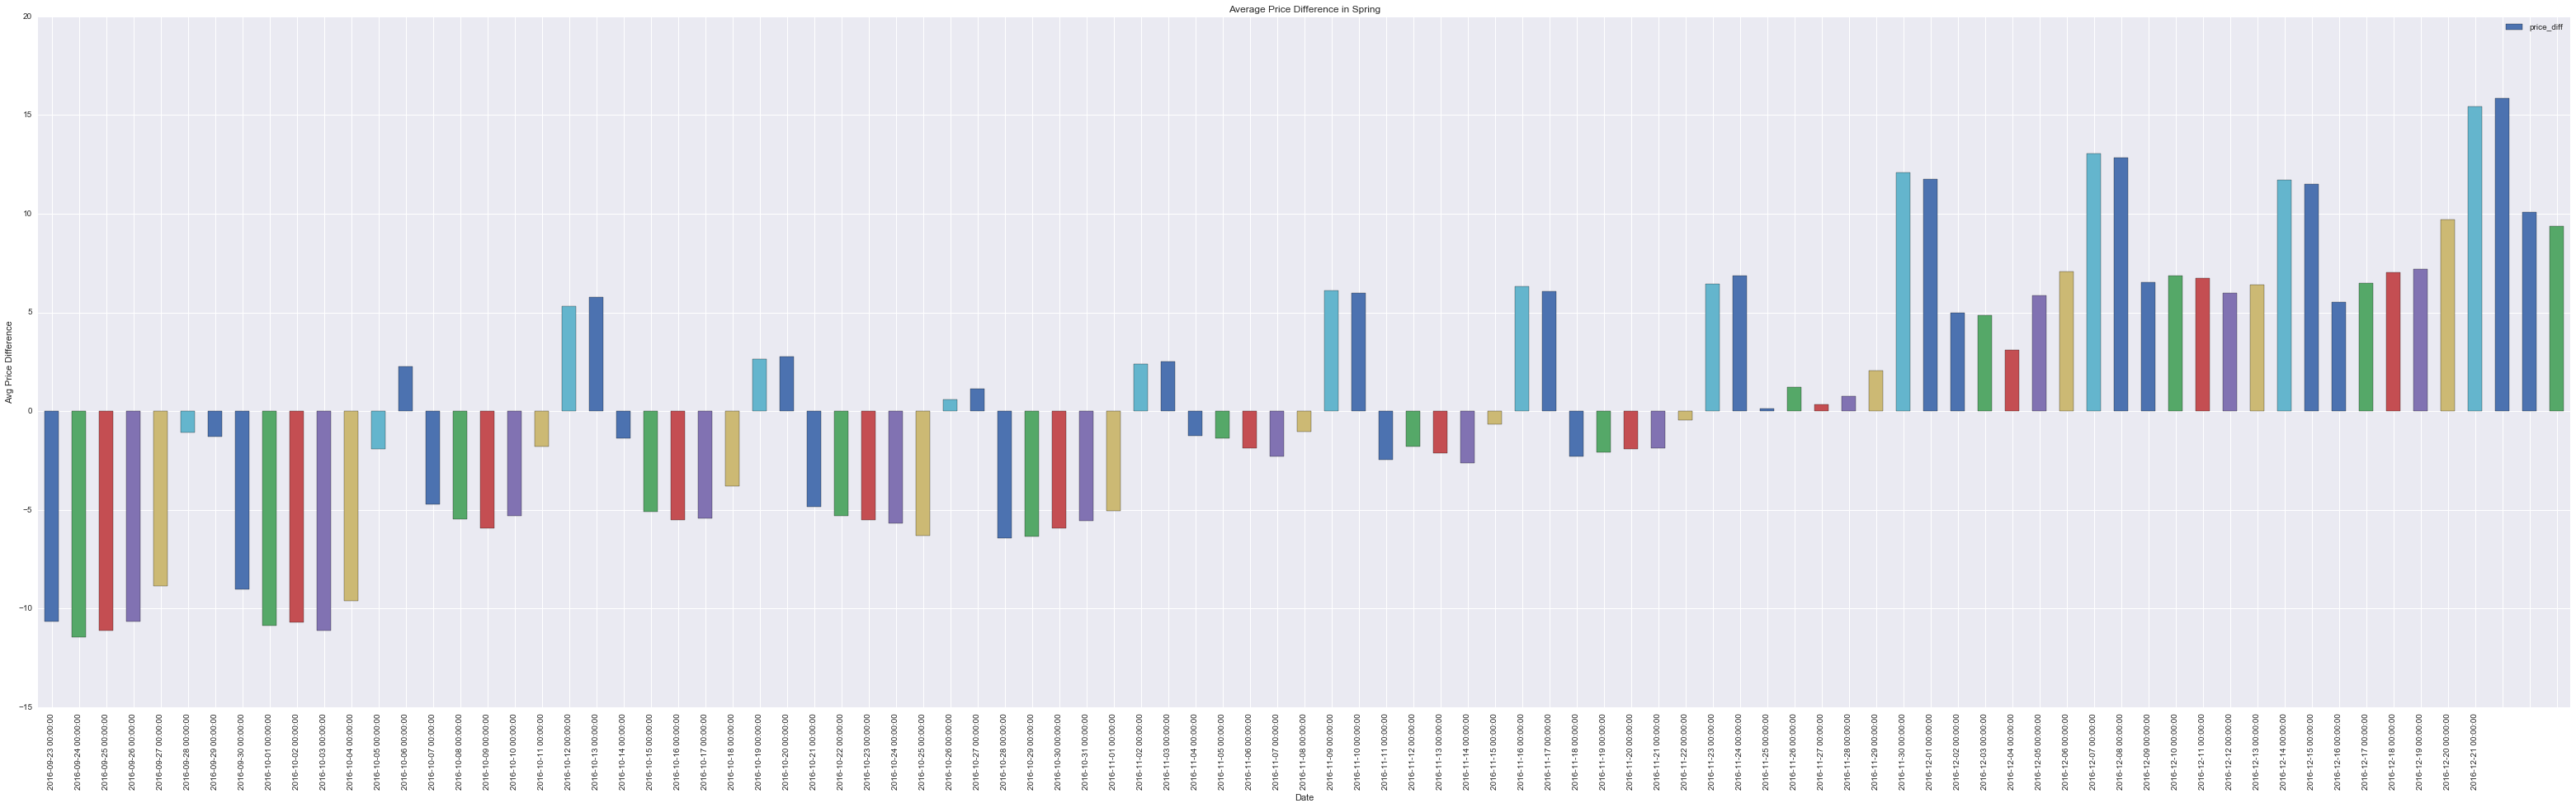

In [73]:
#FALL
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
spring.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(fall['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Spring')
plt.show()